In [17]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sys.path.append('../src/')
from experiments.evaluate_from_config import agent_from_config
import experiments.parameters as parameters
from core.runner import run_episode
from core.node import Node


In [18]:



challenge = parameters.env_challenges[1]
config_modifications = {
    "agent_type": "distance",
    "max_episode_length": 100,
    "tree_evaluation_policy": "mvc",
    "selection_policy": "PolicyUCT",
    "planning_budget": 128,
    "puct_c": 2.0,

    }

run_config = {**parameters.base_parameters, **challenge, **config_modifications}
agent, env, tree_evaluation_policy, observation_embedding, planning_budget = (
    agent_from_config(run_config)
)
results, trees = run_episode(
    agent,
    env,
    tree_evaluation_policy,
    observation_embedding,
    planning_budget=run_config["planning_budget"],
    max_steps=100,
    seed=None,
    temperature=run_config["eval_temp"],
    return_trees=True,
    )
results

TensorDict(
    fields={
        actions: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.bool, is_shared=False),
        observations: Tensor(shape=torch.Size([100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        policy_distributions: Tensor(shape=torch.Size([100, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        rewards: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
        root_values: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.float32, is_shared=False),
        terminals: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)

In [19]:
from matplotlib import colors
ncols, nrows = observation_embedding.ncols, observation_embedding.nrows
cliff_coords = [(nrows - 1, col) for col in range(1, ncols - 1)]
goal_coord = (nrows - 1, ncols - 1)
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(tree: Node, ncols, nrows):
    visitation_counts = tree.state_visitation_counts()
    density = np.zeros((nrows, ncols))
    for state, count in visitation_counts.items():
        if state == None:
            row, col = goal_coord
        else:
            row, col = obs_to_cords(state, ncols)
        density[row, col] = count
    return density


In [20]:

def plot_denisity(tree: Node, ncols=ncols, nrows=nrows):
    density = calculate_density(tree, ncols, nrows)
    for (row, col) in cliff_coords:
        density[row, col] = np.nan  # Remove numbers from the cliff cells
    # goal_row, goal_col = goal_coord
    # density[goal_row, goal_col] = np.nan  # Remove numbers from the goal cell

    # Create a custom colormap to highlight cliff and goal
    cmap = sns.color_palette("Greens", as_cmap=True)

    # Mask the 0.0 entries by setting them to NaN
    density[density == 0.0] = np.nan


    # Plot the heatmap
    ax = sns.heatmap(density, cmap=cmap, cbar=False, annot=True, fmt='.0f', mask=np.isnan(density))
    root_state = tree.observation
    # mark the root state by a red border
    root_row, root_col = obs_to_cords(root_state, ncols)
    ax.add_patch(plt.Rectangle((root_col, root_row), 1, 1, fill=False, color='red', lw=4))


    for (row, col) in cliff_coords:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=True, color='black', lw=0))

        # Highlight the goal state with yellow color
        # ax.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1, fill=True, color='yellow', lw=0))

        ax.set_xticks(range(ncols))
        ax.set_yticks(range(nrows))
        ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square

    return ax


MovieWriter ffmpeg unavailable; using Pillow instead.


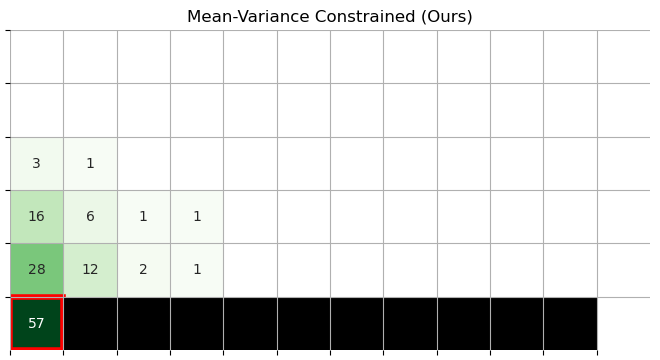

In [22]:

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# title = f'{run_config["env_description"]}_{run_config["tree_evaluation_policy"]}_{run_config["selection_policy"]}_{run_config["planning_budget"]}_{run_config["puct_c"]}'
title = f'Mean-Variance Constrained (Ours)'
def animate_density(trees, ncols=observation_embedding.ncols, nrows=observation_embedding.nrows):
    fig, ax = plt.subplots()
    # remove space around the plot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    def update(frame):
        ax.clear()
        ax.set_title(title)
        plot_denisity(trees[frame], ncols, nrows)
        # add grid
        ax.grid(True)

    anim = FuncAnimation(fig, update, frames=len(trees), repeat=False)
    return anim

anim = animate_density(trees)
# show in notebook on mac
anim.save(f"outfiles/{title}.gif", fps=2)
HTML(anim.to_jshtml())